In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns

category =  "config2"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

In [2]:
hm = 6
window_dim = hm/2/4

velocity_scaling = 1
ventilation_scaling = velocity_scaling/(window_dim**2)

@utils.no_kwargs
@utils.dict_apply
def norm_vel(df):
    return df * velocity_scaling

@utils.no_kwargs
@utils.dict_apply
def norm_vent(df):
    return df * ventilation_scaling

@utils.no_kwargs
@utils.dict_apply
def abs_values(df):
    return df.abs()

@utils.no_kwargs
@utils.dict_apply
def flip_data(df):
    return -df


In [3]:
run = 15
qoisOutputed = ["mass_flux", "comp(u,0)"]
qois= ["mass_flux"]

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'

# probes = probePost.Probes(probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed)
# probes.to_parquet(overwrite = True)

probes = probePost.Probes(probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed, file_type = "parquet")



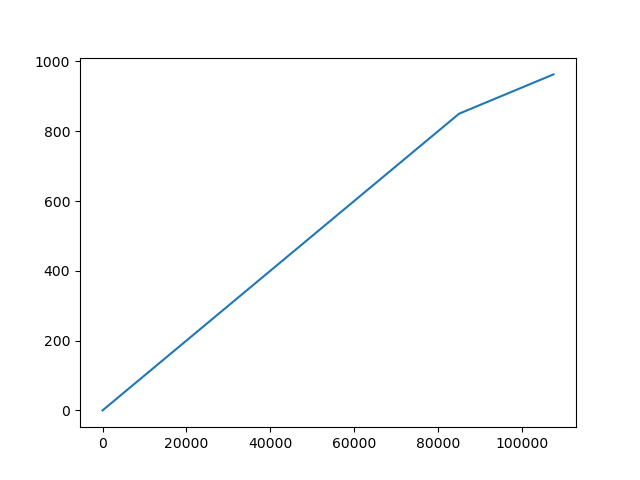

In [4]:
plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)
plt.show()

In [5]:
start = -500
stop = -1
by = 1

(0.0, 2.45)

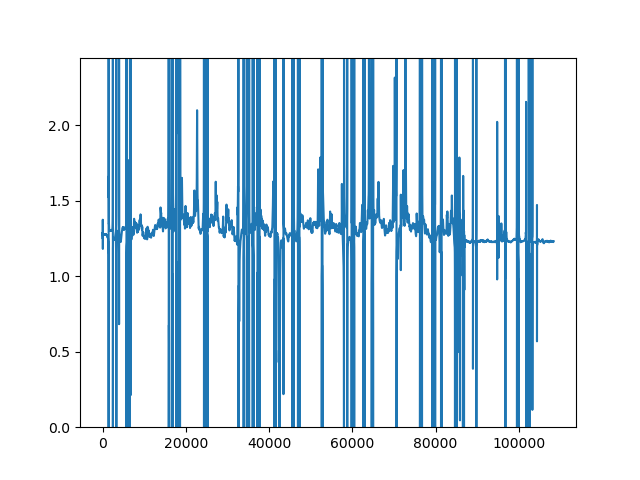

In [6]:
plt.figure()
foo_mass = probes.data[("xwindow_0-0_h_3-0_Bx", qoisOutputed[0])].compute()
foo_u = probes.data[("xwindow_0-0_h_3-0_Bx", qoisOutputed[1])].compute()
foo_area = probes.areas["xwindow_0-0_h_3-0_Bx"]
plt.plot(foo_mass.values/foo_u.values)
plt.ylim(0,1.225*2)


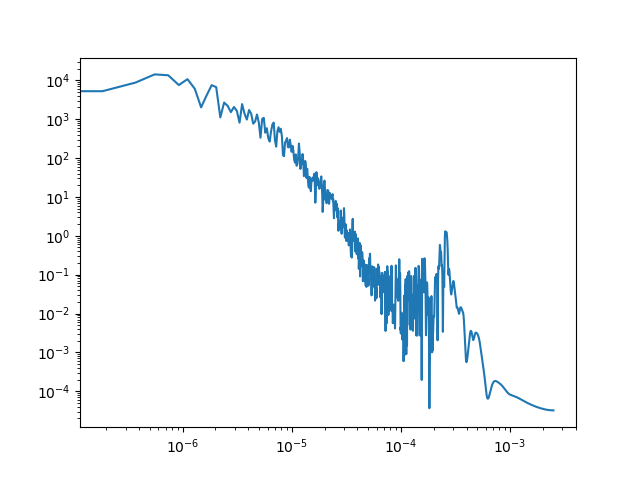

In [7]:
plt.figure()
N = len(foo_mass)
f, E = sp.signal.welch(foo_mass.values, fs = probes.dt, axis = 0, nperseg = N//4, scaling = 'density', detrend = 'constant') 
plt.loglog(f, E)

## X Flow


In [8]:
@utils.no_kwargs
def norm_norm_blocks(data_dict):
    return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bz" in name], -1)

# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "xwindow_" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_blocks],
#     parrallel=True
#     )

## mean statistics
x_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [probePost.time_average, norm_norm_blocks],
    parrallel=False
    )

## rms statistics
x_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [probePost.time_rms],
    parrallel=False
    )

## Net flow
x_net = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [abs_values, probePost.time_average],
    parrallel=False
    )

x_flowStats = pd.concat([x_mean, x_rms, x_net], axis = "index").T
x_flowStats.columns = ["mean", "rms", "net"]

processing data took 7 seconds
processing data took 3 seconds
processing data took 3 seconds


In [9]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/xwindows', bbox = "tight")

# x_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xmean.csv')
# x_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xrms.csv')
# x_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xnet.csv')

## Z Flow


In [10]:
@utils.no_kwargs
def norm_norm_windows(data_dict):
    return probePost.mul_names(data_dict, [name for name in probes.probe_names if "-1_h" in name], -1)

@utils.no_kwargs
def norm_norm_blocks(data_dict):
    return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bx" in name], -1)

# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "zwindow" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_norm_windows, norm_norm_blocks],
#     parrallel=True
#     )

## mean statistics
z_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [probePost.time_average, norm_norm_windows, norm_norm_blocks],
    parrallel=False
    )

## rms statistics
z_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [probePost.time_rms],
    parrallel=False
    )

## Net flow
z_net = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [abs_values, probePost.time_average],
    parrallel=False
    )

z_flowStats = pd.concat([z_mean, z_rms, z_net], axis = "index").T
z_flowStats.columns = ["mean", "rms", "net"]

processing data took 21 seconds
processing data took 8 seconds
processing data took 8 seconds


In [11]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/zwindows', bbox_inches = "tight")

# z_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zmean.csv')
# z_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zrms.csv')
# z_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/znet.csv')

## Y Flow


In [12]:
# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "skylight" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_skylights],
#     parrallel=True
#     )

## mean statistics
y_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [probePost.time_average, flip_data],
    parrallel=False
    )

## rms statistics
y_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [probePost.time_rms],
    parrallel=False
    )

## Net flow
y_net = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [abs_values, probePost.time_average],
    parrallel=False
    )

y_flowStats = pd.concat([y_mean, y_rms, y_net], axis = "index").T
y_flowStats.columns = ["mean", "rms", "net"]

processing data took 4 seconds
processing data took 2 seconds
processing data took 2 seconds


In [13]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/ywindows')

# y_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ymean.csv')
# y_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/yrms.csv')
# y_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ynet.csv')

## All Flow

In [14]:
flowStats = pd.concat([x_flowStats, y_flowStats, z_flowStats], axis = "index")

windowType = []
houseType = []
blockType = []
for window, row in flowStats.iterrows():
    windowData = window.replace("_h_", '_')
    windowData = windowData.split('_')
    if len(windowData) == 3:
        windowData.append('')
    windowType.append(f"{windowData[0]}_{windowData[1]}")
    houseType.append(windowData[2])
    blockType.append(windowData[3])
    
flowStats["windowType"] = windowType
flowStats["houseType"] = houseType
flowStats["blockType"] = blockType

In [15]:
locs = probes.get_avg_locations()

In [16]:
areas = pd.Series(probes.areas)

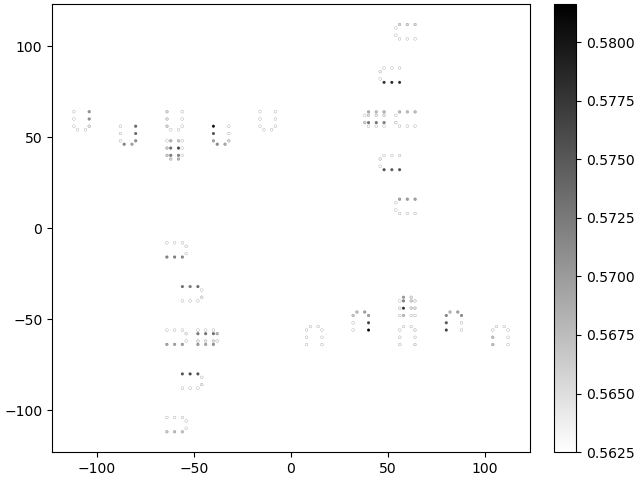

In [17]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s=4, c=areas[flowStats.index], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

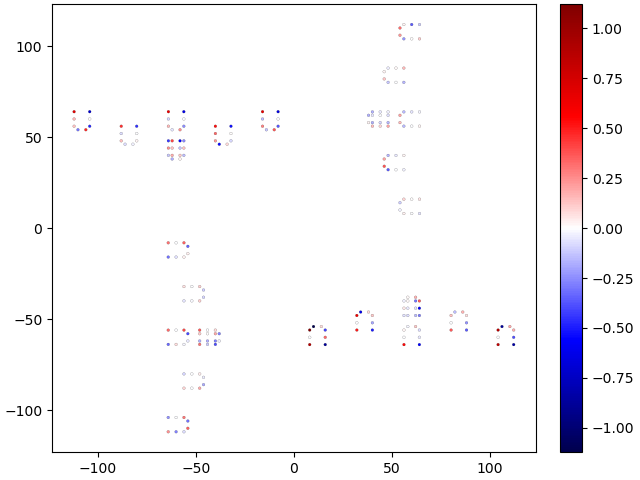

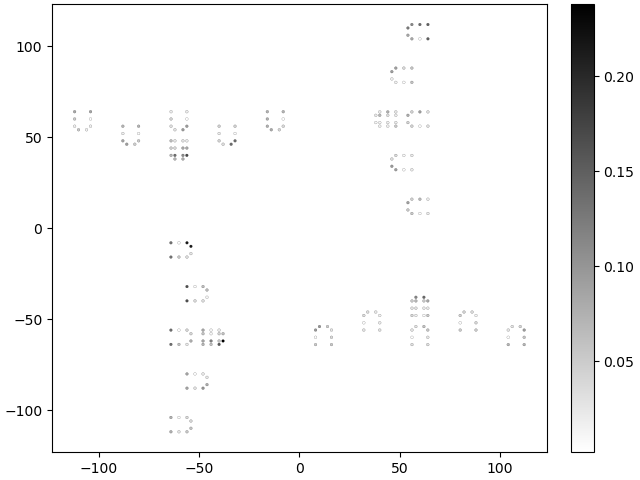

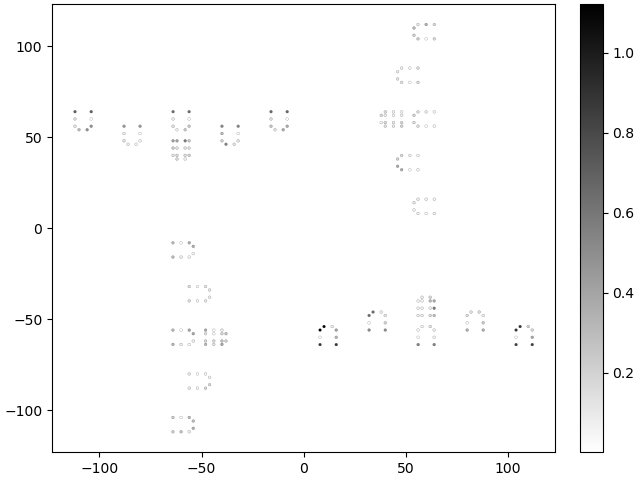

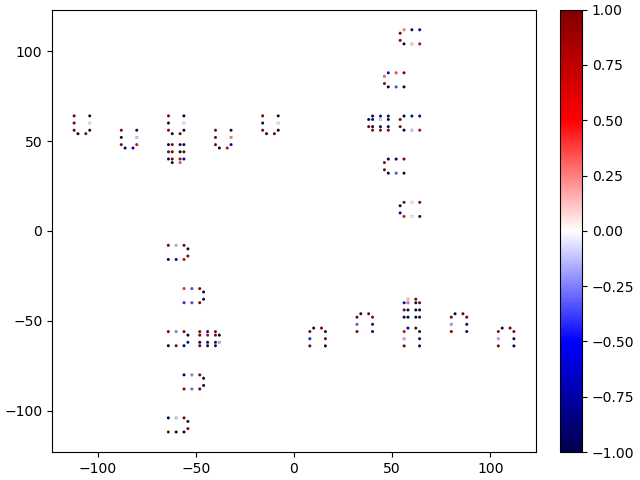

In [18]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s=4, c=flowStats["mean"], cmap='seismic', edgecolors="black", linewidths=.1, norm=colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s=4, c=flowStats["rms"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s=4, c=flowStats["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s=4, c=flowStats["mean"]/flowStats["net"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanOnetInterior', bbox_inches="tight")

In [42]:
flowStats

,mean,rms,net,windowType,houseType,blockType
xwindow_0-0_h_3-0,-0.030132,0.054375,0.055850,xwindow_0-0,3-0,
xwindow_0-0_h_3-0_Bx,0.370187,0.040305,0.370187,xwindow_0-0,3-0,Bx
xwindow_0-0_h_3-0_Bxz,-0.342076,0.214230,0.352072,xwindow_0-0,3-0,Bxz
xwindow_0-0_h_3-0_Bz,-1.121626,0.097580,1.121626,xwindow_0-0,3-0,Bz
xwindow_0-0_h_3-1,0.369701,0.096232,0.369701,xwindow_0-0,3-1,
...,...,...,...,...,...,...
zwindow_2-1_h_3-4_Bz,-0.836421,0.071854,0.836421,zwindow_2-1,3-4,Bz
zwindow_2-1_sl,-0.030221,0.026375,0.036797,zwindow_2-1,sl,
zwindow_2-1_sl_Bx,-0.432469,0.063949,0.432469,zwindow_2-1,sl,Bx
zwindow_2-1_sl_Bxz,0.301485,0.071296,0.301485,zwindow_2-1,sl,Bxz


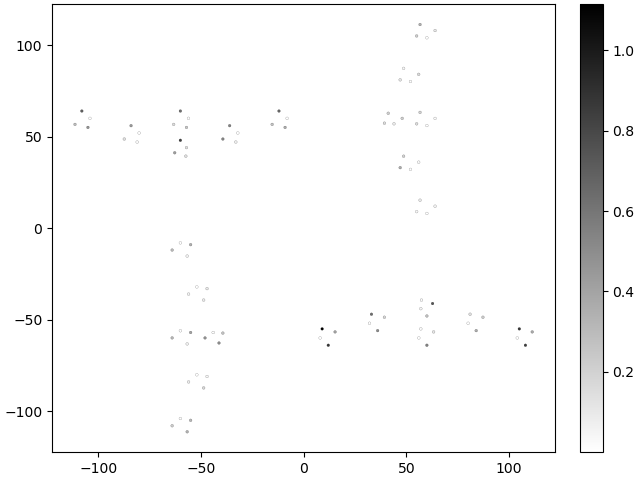

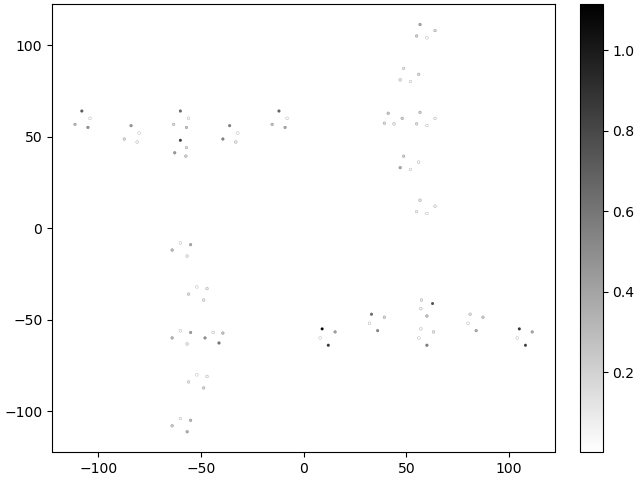

In [73]:
def genKey(type, house, block):
    key = f"{type}_h_{house}_{block}"
    key = key.rstrip('_')
    return key.replace("h_sl", "sl")

houses = set(flowStats["houseType"])
blocks = set(flowStats["blockType"])
roomQois = ["mean", "net"]
dims = ['x', 'y', 'z']

connectedWindows = {
    "corner": [
        "xwindow_0-0",
        "zwindow_0-0",
        "skylight_0-0"
    ],
    "single": [
        "zwindow_1-0",
        "skylight_1-0"
    ],
    "dual": [
        "xwindow_0-1",
        "zwindow_0-1",
        "zwindow_1-1",
        "skylight_0-1",
        "skylight_1-1"
       ],
    "cross": [
        "zwindow_2-0",
        "zwindow_2-1",
        "skylight_2-0",
        "skylight_2-1"
    ]
}
roomVentilation = {}
roomLocs = {}

for windowKey, row in flowStats.iterrows():
    i = 0
    for room, windows in connectedWindows.items():
        i += 1
        if row["windowType"] in windows:
            break
        if i == len(connectedWindows.keys()):
            raise(f"room not found for window f{windowKey}")

    roomKey = genKey(room, row["houseType"], row["blockType"])
    if roomKey not in roomVentilation:
        roomVentilation[roomKey] = {}
        for qoi in roomQois:
            roomVentilation[roomKey][qoi] = 0
    if roomKey not in roomLocs:
        roomLocs[roomKey] = {}
        for d in dims:
            roomLocs[roomKey][d] = []
    for qoi in roomQois:
        roomVentilation[roomKey][qoi] += np.abs(flowStats.loc[windowKey, qoi]) / 2
    for d in dims:
        roomLocs[roomKey][d].append(locs.loc[windowKey, d])
    
    roomVentilation[roomKey].update(row[["houseType", "blockType"]])
    roomVentilation[roomKey]["roomType"] = room

roomVentilation = pd.DataFrame(roomVentilation).T  
roomLocs = pd.DataFrame(roomLocs).T
roomLocs = roomLocs.map(lambda L: np.mean(L))

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomLocs.loc[roomVentilation.index, 'x'], roomLocs.loc[roomVentilation.index, 'z'], s=4, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomLocs.loc[roomVentilation.index, 'x'], roomLocs.loc[roomVentilation.index, 'z'], s=4, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRooms', bbox_inches="tight")

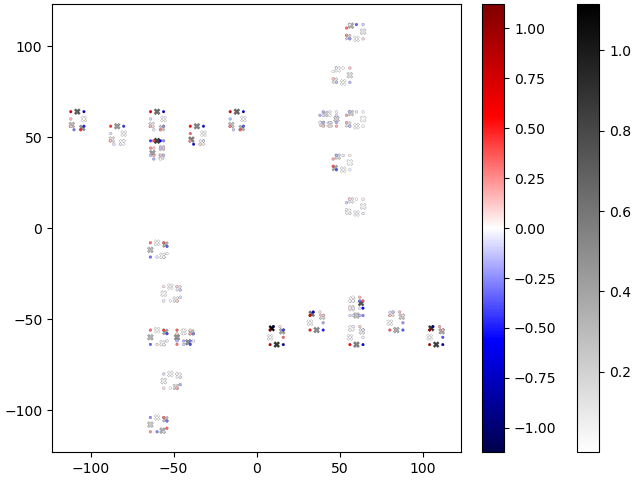

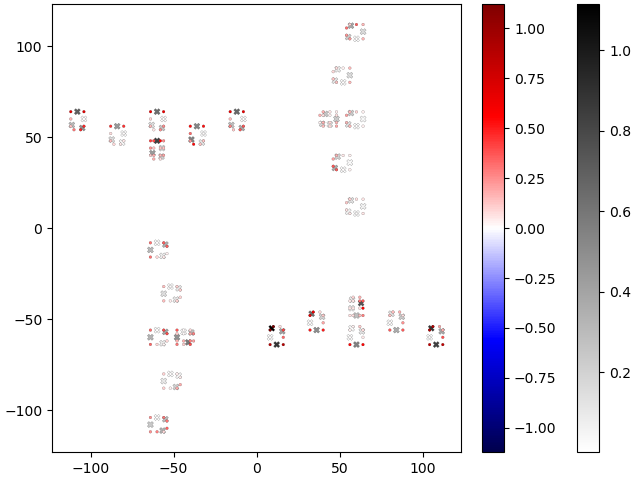

In [70]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomLocs.loc[roomVentilation.index, 'x'], roomLocs.loc[roomVentilation.index, 'z'], s=20, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s=4, c=flowStats["mean"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanWindowsRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomLocs.loc[roomVentilation.index, 'x'], roomLocs.loc[roomVentilation.index, 'z'], s=20, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s=4, c=flowStats["net"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netWindowsRooms', bbox_inches="tight")

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/groups/gorl

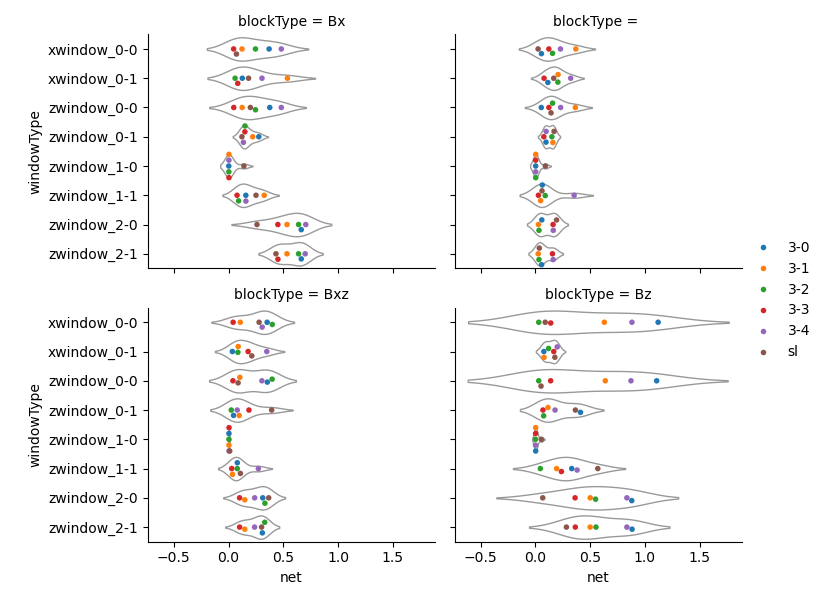

In [21]:
windowList = flowStats[flowStats["houseType"] != "sl"]["windowType"]
                                                       
dfPlot = flowStats.loc[flowStats["windowType"].isin(windowList)]

g = sns.FacetGrid(dfPlot, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "net", "windowType", color = "1", inner = None, linewidth = 1, density_norm = "width")
g.map(sns.swarmplot, "net", "windowType", "houseType", palette = "tab10", size = 4)
g.add_legend()

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


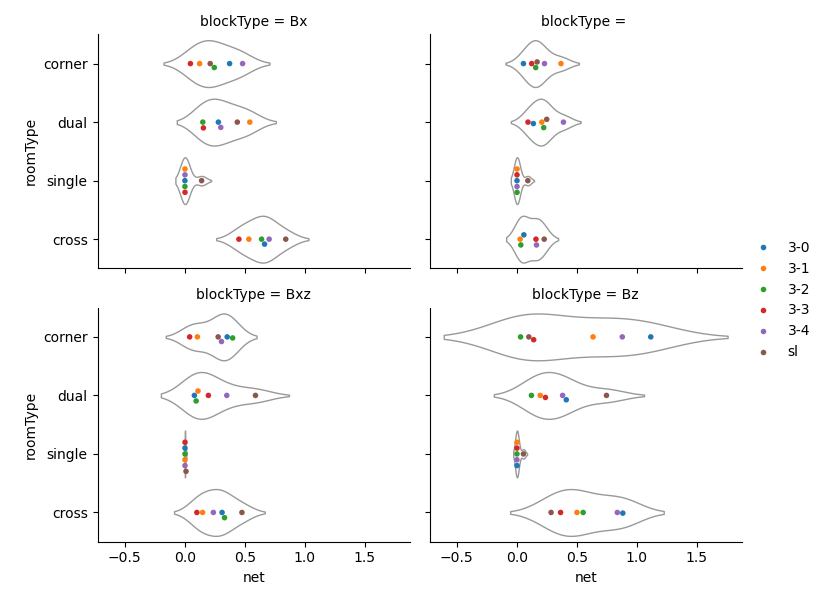

In [74]:
roomVentilation
g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "net", "roomType", color = "1", inner = None, linewidth = 1, density_norm = "width")
g.map(sns.swarmplot, "net", "roomType", "houseType", palette = "tab10", size = 4)
g.add_legend()

## Convergence

In [22]:
data = probes.statistics(
    names = [name for name in probes.probe_names if "door" not in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [],
    parrallel=False
    )

processing data took 12 seconds


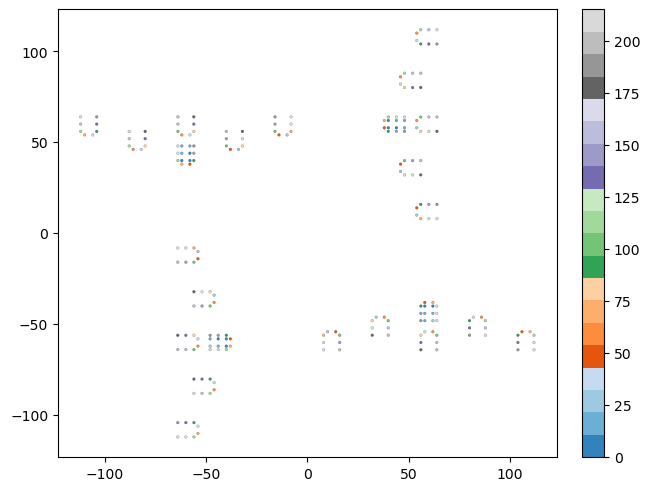

In [23]:
xPlot = data.index.values
yPlot = np.arange(len(data.keys()))

fig, ax=plt.subplots(1, 1, constrained_layout = True)
im=ax.scatter(locs.loc[data.keys(), 'x'], locs.loc[data.keys(), 'z'], s=4, c=yPlot, cmap='tab20c', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/dataMap', bbox_inches="tight")

In [ ]:
dataCumMean = probePost.cumulative_mean(data)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataCumMean.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)
# ax.set_yticks(yPlot)
# ax.set_yticklabels(dataCumMean.keys())

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourCumMean', bbox_inches="tight")

In [ ]:
dataConv = probePost.convergence(dataCumMean)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataConv.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourConv', bbox_inches="tight")

In [ ]:
dataRevCumMean = probePost.reverse(data)
dataRevCumMean = probePost.cumulative_mean(dataRevCumMean)
dataRevCumMean = probePost.reverse(dataRevCumMean)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataRevCumMean.abs().T, cmap = "inferno", levels=40, vmax = 1)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourRevCumMean', bbox_inches="tight")

In [ ]:
@utils.no_kwargs
@utils.dict_apply
def sma(df): 
    return df.rolling(80000).mean()
    
dataSMA = sma(data)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataSMA.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourSMA', bbox_inches="tight")